<table align="left">
  <td>
    <a href="https://tinyurl.com/2fa4l47p" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Transfer Learning con TensorFlow

## Parte 2. Fine-tuning

**Transfer learning** es una técnica de aprendizaje automático que nos permite aprovechar los patrones aprendidos por un modelo en un problema para resolver otro problema.


En **fine-tuning transfer learning**, los pesos pre-entrenados de otro modelo se descongelan y se ajustan durante el entrenamiento para adaptarse mejor a sus propios datos.

Para **feature extraction transfer learning**, solo se puede entrenar las 1-3 primeras capas de un modelo pre-entrenado con sus propios datos, en el aprendizaje de transferencia **fine-tuning**, puede entrenar 1-3+ capas de un modelo pre-entrenado (donde el '+' indica que muchas o todas las capas podrían entrenarse).

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png" width="600"/>


:book: **Vamos a ver lo siguiente con TensorFlow:**

- Introducción a fine-tuning, un tipo de aprendizaje de transferencia para modificar un modelo pre-entrenado para que sea más adecuado para sus datos. 
- Uso de la **API Funcional de Keras** (una manera diferente de construir modelos en Keras).
- Uso de un dataset más pequeño para experimentar más rápido (por ejemplo, 1-10% de muestras de entrenamiento de 10 clases de alimentos).
- Aumento de datos (cómo hacer que su conjunto de datos de entrenamiento sea más diverso sin agregar más datos).
- Ejecución de una serie de experimentos de modelado en nuestros datos de Food Vision.
    - Modelo 0: un modelo de aprendizaje de transferencia usando la API Funcional de Keras.
    - Modelo 1: un modelo de extracción de características de aprendizaje de transferencia en 1% de los datos con aumento de datos.
    - Modelo 2: un modelo de extracción de características de aprendizaje de transferencia en 10% de los datos con aumento de datos.
    - Modelo 3: un modelo de aprendizaje de transferencia de fine-tuning en 10% de los datos.
    - Modelo 4: un modelo de aprendizaje de transferencia de fine-tuning en 100% de los datos.
- Introducción del callback ModelCheckpoint para guardar los resultados de entrenamiento intermedios.
- Comparación de los resultados de los experimentos de modelos usando TensorBoard.


In [4]:
import tensorflow as tf
import helper_functions as hf
import numpy as np
import os

## 1. Descargar los Datos

En este notebook, vamos a ver como podemos utilizar los modelos pre-entrenados que se encuentran en `tf.keras.applications` para resolver nuestro problema de clasificación de alimentos.

[**tf.keras.applications**](https://www.tensorflow.org/api_docs/python/tf/keras/applications) es un módulo que contiene modelos pre-entrenados con pesos pre-entrenados. Estos modelos se pueden usar para hacer predicciones o para transferir el aprendizaje.

Se utilizará el 10% de las muestras de entrenamiento de 10 clases de comida de Food101. 

In [2]:
# Get data (10% of labels)
import zipfile
import os
if(os.path.exists('10_food_classes_10_percent')):
    print('Files exists')
else:
    # Download data
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    
    # Unzip the downloaded file
    zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
    zip_ref.extractall()
    zip_ref.close()
    print("Dataset is ready")

Files exists


In [3]:
# Recorrer el directorio para verificar el contenido del folder
hf.walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test

In [4]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

> :eye: **Nota.**

Cuando se utiliza **`image_data_from_directory()`** para cargar imágenes, no es necesario definir el **`ImageDataGenerator()`** para el conjunto de datos de entrenamiento y prueba.

Anteriormente, hemos utilizado la clase ImageDataGenerator. Y aunque esto funciona bien y todavía se usa mucho, esta vez utilizaremos la función `image_data_from_directory()`.

Una de las principales ventajas de usar `tf.keras.prepreprocessing.image_dataset_from_directory()` en lugar de `ImageDataGenerator` es que crea un objeto `tf.data.Dataset` en lugar de un generador. La principal ventaja de esto es que la API `tf.data.Dataset` es mucho más eficiente (más rápida) que la API ImageDataGenerator, lo que es fundamental para conjuntos de datos más grandes.

In [8]:
# ImageDataGenerator para entrenamiento y test
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

print('Training images:')
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode='categorical',
                                                                            image_size=IMAGE_SHAPE,
                                                                            batch_size=BATCH_SIZE,
                                                                            seed=42)
print('Test images:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMAGE_SHAPE,
                                                                batch_size=BATCH_SIZE, 
                                                                seed=42)


Training images:
Found 750 files belonging to 10 classes.
Test images:
Found 2500 files belonging to 10 classes.


In [9]:
# Verificar el contenido de los datasets
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

> :key: **En el resultado anterior**:

- (None, 224, 224, 3) se refiere a la forma del tensor de nuestras imágenes donde None es el tamaño del lote, 224 es la altura (y ancho) y 3 es los canales de color (rojo, verde, azul).
- (None, 10) se refiere a la forma del tensor de las etiquetas donde None es el tamaño del lote y 10 es el número de etiquetas posibles (las 10 clases de alimentos diferentes).
- Tanto los tensores de imágenes como las etiquetas son del tipo de datos tf.float32.
- El tamaño del lote es None debido a que solo se usa durante el entrenamiento del modelo. Puede pensar en None como un marcador de posición esperando ser llenado con el parámetro batch_size de image_dataset_from_directory().
- Otra ventaja de usar la API tf.data.Dataset son los métodos asociados que vienen con ella. Por ejemplo, podemos usar el método `prefetch()` para asegurarnos de que el modelo no se quede sin datos mientras se está entrenando. Esto es especialmente útil cuando se trabaja con conjuntos de datos grandes.
- El método `class_names` nos da el nombre de las clases de alimentos en el orden en que se encuentran en el tensor de etiquetas.

<a href="https://ibb.co/BzyX7Wm"><img src="https://i.ibb.co/6nH3p92/datasetfromdirectory.png" alt="datasetfromdirectory" border="0"></a>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.10000000e+02 6.32397957e+01 0.00000000e+00]
   [1.18780609e+02 7.49744949e+01 7.37755108e+00]
   [1.06168365e+02 6.54438782e+01 1.02551079e+00]
   ...
   [9.51429443e+01 5.70000000e+01 2.21426392e+00]
   [1.04714348e+02 6.15000267e+01 8.57146740e+00]
   [1.10357109e+02 6.33571091e+01 9.35710812e+00]]

  [[1.14693878e+02 7.08877563e+01 4.36224604e+00]
   [1.14423470e+02 7.30051041e+01 7.14285660e+00]
   [1.10346939e+02 7.12346954e+01 6.29081631e+00]
   ...
   [9.44694366e+01 5.59285736e+01 1.34179497e+00]
   [1.00285751e+02 5.70714264e+01 4.14286995e+00]
   [1.07311264e+02 5.74490089e+01 4.40309334e+00]]

  [[1.07239792e+02 6.82346954e+01 7.65306503e-02]
   [1.13382652e+02 7.48112259e+01 7.59694004e+00]
   [1.13469383e+02 7.48520432e+01 9.94387722e+00]
   ...
   [9.81888351e+01 5.96173630e+01 5.04589176e+00]
   [1.02857155e+02 5.68571548e+01 4.85715580e+00]
   [1.09576607e+02 5.95766068e+01 6.57660770e+00]]

  ...

  [[9.08060455e+01 6.93775177e+01 2.37751961e+00]
   [9

## Modelo 0: Crear un modelo usando la API Funcional de Keras

**Baseline model**

Vamos a ver como podemos utilizar los modelos pre-entrenados que se encuentran en `tf.keras.applications` para resolver nuestro problema de clasificación de alimentos así como la **API Functional** de keras para construir el modelo.

Seguiremos los siguientes pasos:
1. Instanciar un modelo pre-entrenado de base eligiendo un modelo objetivo como EfficientNetB0 desde tf.keras.applications, configurando el parámetro include_top en False (hacemos esto porque vamos a crear nuestra propia parte superior, que son las capas de salida para el modelo).
2. Establecer el atributo trainable del modelo base en False para congelar todos los pesos en el modelo pre-entrenado.
3. Definir una capa de entrada para nuestro modelo, por ejemplo, ¿qué forma de datos debería esperar nuestro modelo?
4. [Opcional] Normalizar las entradas de nuestro modelo si lo requiere. Algunos modelos de visión por computadora como ResNetV250 requieren que sus entradas estén entre 0 y 1.

🤔 Nota: Al escribir esto, los modelos EfficientNet en el módulo tf.keras.applications no requieren que las imágenes se normalicen (valores de píxeles entre 0 y 1) en la entrada, mientras que muchos de los otros modelos lo hacen.

1. Pasar las entradas al modelo base.
2. Pool las salidas del modelo base en una forma compatible con la capa de activación de salida (convertir tensores de salida de modelo base en la misma forma que los tensores de etiquetas). Esto se puede hacer utilizando tf.keras.layers.GlobalAveragePooling2D().
3. Crear una capa de salida que produzca un tensor de la forma (None, 10) donde None es el tamaño del lote y 10 es el número de etiquetas posibles (las 10 clases de alimentos diferentes).
4. Combinar las capas de entrada y salida en un modelo usando tf.keras.Model().
5. Compilar el modelo definiendo la función de pérdida y el optimizador.
6. Ajustar el modelo (entrenar) pasando el conjunto de datos de entrenamiento al modelo.

### Keras Sequential API vs Keras Functional API

<a href="https://ibb.co/Qr9wnkK"><img src="https://i.ibb.co/vZ1nmhj/sequentialvsfunctional.png" alt="sequentialvsfunctional" border="10" width="800"></a>

- Similaridad: Ambos APIs permiten crear, compilar, entrenar y evaluar modelos de Keras.
- Diferencia: La API Funcional es más flexible que la API Secuencial. La [API Funcional](https://www.tensorflow.org/guide/keras/functional?hl=es-419) se puede utilizar para crear modelos que no son secuenciales, como modelos con múltiples entradas y salidas, modelos con capas compartidas y modelos con múltiples caminos.


In [12]:
# Model 0: Construir un modelo de Transfer Learning con la API Functional

#  1. Crear el modelo base utilizando tf.keras.applications.EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # No incluir la capa de clasificación

# 2. Congelar el modelo base (no entrenar los pesos)
base_model.trainable = False

# 3. Crear las entradas del modelo
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# 4. Si se desea, se puede agregar una capa de preprocesamiento - Dependiendo del modelo base (por ejemplo, ResNet50V2)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pasar los datos de entrada a través del modelo base
x = base_model(inputs, training=False)
print(f'Shape after passing through base model: {x.shape}')

# 6. Average pool las salida del modelo base(Agrupar toda la información más importante, para reducir el número de cálculos )
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after global average pooling: {x.shape}')

# 7. Crear la salida del modelo
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combinar entradas y salidas en un modelo
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compilar el modelo
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Resumen del modelo
model_0.summary()

16719872/16705208 [==============================] - 3s 0us/step
Shape after passing through base model: (None, 7, 7, 1280)
Shape after global average pooling: (None, 1280)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
# Entrenar el modelo
history_10_percent = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)), # Solo evaluar 25% de los datos de test
                        callbacks=[hf.create_tensorboard_callback(dir_name='transfer_learning',
                                                                experiment_name='10_percent_feature_extract')],
                        verbose=1)
# Evaluar el modelo

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20221231-084112


c:\Users\diego\anaconda3\envs\gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
24/24 [==============================] - 22s 320ms/step - loss: 1.8161 - accuracy: 0.4547 - val_loss: 1.2671 - val_accuracy: 0.7582
Epoch 2/5
24/24 [==============================] - 5s 187ms/step - loss: 1.0721 - accuracy: 0.7747 - val_loss: 0.8560 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 5s 181ms/step - loss: 0.7844 - accuracy: 0.8267 - val_loss: 0.6726 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 5s 187ms/step - loss: 0.6374 - accuracy: 0.8547 - val_loss: 0.6096 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 5s 190ms/step - loss: 0.5448 - accuracy: 0.8827 - val_loss: 0.5704 - val_accuracy: 0.8503


In [16]:
model_0.evaluate(test_data)

79/79 [==============================] - 8s 93ms/step - loss: 0.5973 - accuracy: 0.8448


[0.597314178943634, 0.8447999954223633]

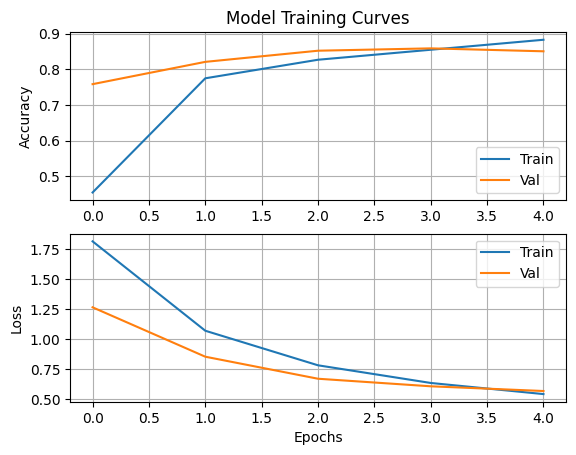

In [15]:
# Graficar las curvas de perdida y accuracy
hf.plot_training_curves(history_10_percent)

In [18]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

### Obtener un Vector de Características del Modelo Entrenado

**Global Average Pooling**: Tanto en la arquitectura **AlexNet** como en la **VGG19**, el mapa de características generado por la última capa convolucional se convierte en un vector (aplanado) y luego se introduce en una o más capas totalmente conectadas (véase la Figura 3-22). El objetivo es terminar en una capa totalmente conectada activada por softmax con exactamente tantas neuronas como clases haya en el problema de clasificación en cuestión. Esta capa totalmente conectada tiene pesos de entrada * salida, que suelen ser muchos.

Si el único objetivo es obtener N valores para alimentar una función softmax de N clases, hay una manera fácil de conseguirlo: ajustar la pila convolucional para que termine **en un mapa de características final con exactamente N canales** y simplemente p**romediar los valores en cada canal**, como se muestra en la siguiente figura. Esto se conoce como Gloval Average Pooling. El promediado global no implica pesos aprendibles, por lo que desde esta perspectiva tiene un bajo costo computacional. 


> :eye: **Note:** Demostración del funcionamiento de la capa `GlobalAveragePooling2D()`.

<a href="https://imgbb.com/"><img src="https://i.ibb.co/QpG0zFG/global-average-pooling.png" alt="global average pooling" border="0"></a>

Se tiene un tensor despues que el modelo pasa la parte base (`base_model`) de shape (None, 7, 7, 1280).

Pero cuando pasa por la capa `GlobalAveragePooling2D()` se transforma en (None, 1280).

- **Ejemplo**: Se utiliza un tensor con una forma similar (1, 4, 4, 3) y se pasa por una capa `GlobalAveragePooling2D()`.

In [3]:
# Definir la forma (shape) de las entradas
input_shape = (1 , 4, 4, 3)

# Crear un tensor de prueba
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor: \n {input_tensor}\n')

# Pasar el tensor aleatorio a través de una capa de global average pooling 2D.
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled tensor: \n {global_average_pooled_tensor}\n')

# Verificar la forma del tensor
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of 2D global average pooled tensor: {global_average_pooled_tensor.shape}')

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global average pooled tensor: (1, 3)


In [4]:
# Replicar la capa GlobalAveragePooling2D
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> :eye: **Nota:** Un vector de características es una representación sobre lo aprendido de los datos de entrada ( Una forma comprimida de como el modelo ve los datos de entrada). 

<a href="https://ibb.co/1q9NgKr"><img src="https://i.ibb.co/fpCWgtk/feature-extractor.png" alt="feature-extractor" border="0"></a>

- **Efficientnet Feature Extractor**

<a href="https://ibb.co/GdY1T4t"><img src="https://i.ibb.co/CwCX23M/efficientnet-fe.png" alt="efficientnet-fe" border="0"></a>

## Experimentos de Transfer Learning

Hemos visto el resultado de aplicar transfer learning utilizando el 10% de los datos de entrenamiento, pero ¿qué pasaría si usamos el 1% de los datos de entrenamiento?. 

<a href="https://ibb.co/qM3gGPR"><img src="https://i.ibb.co/99k4XCq/experimentos-tf.png" alt="experimentos-tf" border="0"></a>

1. `model_1` - Utilizar feature extraction transfer learning con el 1% de los datos de entrenamiento y data augmentation.
2. `model_2` - Utilizar feature extraction transfer learning en 10% de los datos de entrenamiento y data augmentation.
3. `model_3` - Utilizar fine-tuning transfer learning en 10% de los datos de entrenamiento y data augmentation.
4. `model_4` - Utilizar fine-tuning transfer learning en 100% de los datos de entrenamiento y data augmentation.

> :key: **Nota:** En todos los modelos se utilizaran los mismos datos de prueba para evaluar el modelo. Esto asegura la consistencia en en todas las metricas de evaluación. 

### Obtener y Preparar los datos para el `model_1`

In [1]:
# Get data (10% of labels)
import zipfile
import os
if(os.path.exists('10_food_classes_1_percent')):
    print('Files exists')
else:
    # Download data
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
    
    # Unzip the downloaded file
    zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip", "r")
    zip_ref.extractall()
    zip_ref.close()
    print("Dataset is ready")

Files exists


In [2]:
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

In [5]:
# Cuántas imágenes hay en el directorio de datos
hf.walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [6]:
# ImageDataGenerator para entrenamiento y test
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

print('Training images:')
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode='categorical', # one_hot=True
                                                                            image_size=IMAGE_SHAPE,
                                                                            batch_size=BATCH_SIZE,
                                                                            seed=42)
print('Test images:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMAGE_SHAPE,
                                                                batch_size=BATCH_SIZE, 
                                                                seed=42)

Training images:
Found 70 files belonging to 10 classes.
Test images:
Found 2500 files belonging to 10 classes.


### Agregando Data Augmentation

En este experimento se agregará data augmentation directamente como una capa del modelo, esto se hace con la clase: 

* `tf.keras.layers.experimental.preprocessing()`.

* [:book: Capas de Preprocesado de Keras](https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers)

:key: **Nota:** Una de las ventajas de utilizar Data Augmentation como una capa del modelo, es que hace uso de la GPU para aumentar la velocidad de entrenamiento. Además, el preprocesamiento de los datos solo ocurre durante el proceso de entrenamiento, no durante la inferencia.

<a href="https://ibb.co/NpnXWpd"><img src="https://i.ibb.co/1KJ3RKt/Data-augmentation-layer.png" alt="Data-augmentation-layer" border="0"></a>

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Crear la capa de data augmentation utilizando horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
], name="data_augmentation")

In [25]:
# Capa utilizada para resizing y rescaling de las imágenes - No es necesario para EfficientNet
IMG_SIZE = 240 # All images will be resized to 240x240
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255) # Se puede utilizara para modelos ResNet50V2 o VGG16. EfficientNet no lo requiere.
])

### Visualizar los datos aumentados

Imagen aleatoria: 2516795.jpg
Path de la imagen seleccionada: 10_food_classes_1_percent/train/chicken_curry/2516795.jpg
Shape of original image: (512, 512, 3)
Shape of image after tf.expand_dims: (1, 512, 512, 3)
Shape of augmented image: (1, 521, 512, 3)
Shape of image after tf.squeeze: (521, 512, 3)


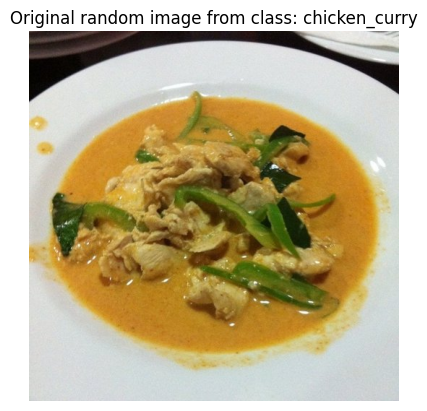

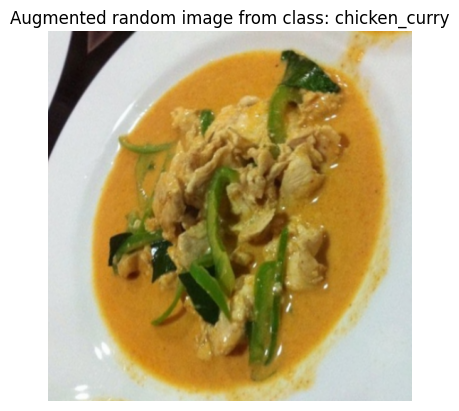

In [37]:
# Visualizar una imagen y ver como cambia con cada paso de data augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class

random_image = random.choice(os.listdir(target_dir))
print(f"Imagen aleatoria: {random_image}")
random_image_path = target_dir + "/" + random_image
print(f"Path de la imagen seleccionada: {random_image_path}")

# Leer la imagen y cambiar su tamaño
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes
print(f"Shape of original image: {img.shape}")
img2 = tf.expand_dims(img, axis=0)
print(f"Shape of image after tf.expand_dims: {img2.shape}") # se agrega una dimensión para indicar que es una imagen del batch

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training = True) # data augmentation model requires shape (None, height, width, 3)
print(f"Shape of augmented image: {augmented_img.shape}")
img3 = tf.squeeze(augmented_img)/255. # remove the extra dimension and normalize the pixel values
print(f"Shape of image after tf.squeeze: {img3.shape}")
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

### Model 1 - Feature Extraction Transfer Learning con 1% de los datos de entrenamiento y data augmentation

Al utilizar el 1% de los datos de entrenamiento, el modelo se entrena en 7 imágenes por clase, lo que significa que el modelo se entrena en 70 imágenes en total.

In [39]:
# Definir una shape y un modelo base, congelando las capas del modelo base
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Crear la capa de entrada del modelo
inputs = layers.Input(shape=input_shape, name="input_layer")

# Agregar data augmentation dentro del modelo como una capa
x = data_augmentation(inputs)

# Dar al base_model las entradas (después de la data augmentation) y no entrenarlo
x = base_model(x, training=False)

# GlobalAveragePooling2D para convertir las características en un vector de 1D)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Capa de salida con 10 neuronas y activación softmax
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Crear el modelo
model_1 = keras.Model(inputs, outputs)

# Compilar el modelo
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Resumen del modelo
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [40]:
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),  # número de batches que se ejecutan por epoch
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)), # número de batches que se ejecutan por epoch
                                callbacks=[hf.create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="1_percent_data_aug")], 
                                verbose=1)

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230113-110739


c:\Users\diego\anaconda3\envs\gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
3/3 [==============================] - 25s 5s/step - loss: 2.4589 - accuracy: 0.1286 - val_loss: 2.2040 - val_accuracy: 0.2089
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1861 - accuracy: 0.1571 - val_loss: 2.0887 - val_accuracy: 0.3109
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9877 - accuracy: 0.4286 - val_loss: 1.9727 - val_accuracy: 0.4112
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8080 - accuracy: 0.5143 - val_loss: 1.8900 - val_accuracy: 0.4260
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6749 - accuracy: 0.5429 - val_loss: 1.8044 - val_accuracy: 0.4836


In [43]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 16s 185ms/step - loss: 1.8069 - accuracy: 0.4620


[1.8069227933883667, 0.4620000123977661]

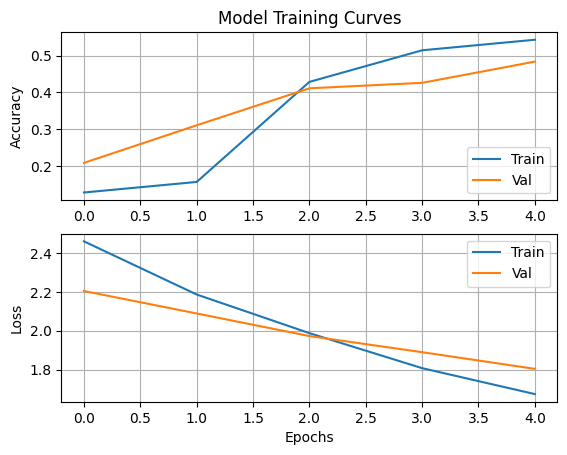

In [42]:
# Evaluar el modelo
hf.plot_training_curves(history_1_percent)

### Model 2 - Feature Extraction Transfer Learning con 10% de los datos de entrenamiento y data augmentation

En este modelo se utilizan 10% de los datos de entrenamiento, lo que significa que el modelo se entrena en 750 imágenes en total.

In [44]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [45]:
# Cargar los datos
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

# Crear la capa de data augmentation utilizando horizontal flipping, rotations, zooms, etc.
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
], name="data_augmentation")

# Crear el modelo usando la api funcional de Keras

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Crear las capas de entrada y salida del modelo
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # pasa las imagenes de entrada por la capa de data augmentation
x = base_model(x, training=False) # pasa las imagenes aumentadas por el modelo base y se congelan sus capas
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # convierte las características en un vector de 1D
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x) # capa de salida con 10 neuronas y activación softmax

model_2 = keras.Model(inputs, outputs)

# Compilar el modelo
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Entrenar el modelo
history_10_percent = model_2.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[hf.create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="10_percent_data_aug")],
                                verbose=1)

In [ ]:
hf.plot_training_curves(history_10_percent)

In [ ]:
# Evaluar el modelo
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug